In [0]:
# Imports
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import numpy as np
from PIL import Image
from tqdm import tqdm_notebook
import operator
import warnings
warnings.filterwarnings('ignore')
##################
from google.colab import drive
drive.mount('/gdrive')
import os
project_dir=('/gdrive/My Drive/Colab Notebooks/Kannada_MNIST')
os.chdir(project_dir)
###############
from keras.models import load_model
cnn_model = load_model('./models/mnist_cnn.h5')

def sanity_check_tri(cnn_model,X_train,X_test):
  
  ##
  x_0=X_train[y_train==0].astype('float32')
  x_0/=255
  pred_acc_0=(cnn_model.predict_classes(x_0)==0).mean()
  ##
  x_3=X_train[y_train==3].astype('float32')
  x_3/=255
  pred_acc_3=(cnn_model.predict_classes(x_3)==2).mean()
  ##
  x_7=X_train[y_train==7].astype('float32')
  x_7/=255
  pred_acc_7=(cnn_model.predict_classes(x_7)==2).mean()
  ##

  ###########################################

  ##
  x_0=X_test[y_test==0].astype('float32')
  x_0/=255
  pred_acc_0t=(cnn_model.predict_classes(x_0)==0).mean()
  ##
  x_3=X_test[y_test==3].astype('float32')
  x_3/=255
  pred_acc_3t=(cnn_model.predict_classes(x_3)==2).mean()
  ##
  x_7=X_test[y_test==7].astype('float32')
  x_7/=255
  pred_acc_7t=(cnn_model.predict_classes(x_7)==2).mean()
  ##
  return (pred_acc_0,pred_acc_3,pred_acc_7,pred_acc_0t,pred_acc_3t,pred_acc_7t)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Using TensorFlow backend.
W0720 21:21:07.754822 139859808675712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 21:21:07.772029 139859808675712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 21:21:07.800852 139859808675712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0720 21:21:07.803440 139859808675712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 21:21:07.805104 139859

# 1: Let's load the datatset(s)

In [0]:
X_Ka_mnist=np.load('./data/output_tensors/X_Ka_mnist_userwise.npy')
y_Ka_mnist=np.load('./data/output_tensors/y_Ka_mnist_userwise.npy')
sanity_check_3=np.load('./data/output_tensors/sanity_check_3.npy')


print(X_Ka_mnist.shape,y_Ka_mnist.shape,sanity_check_3.shape)

(65, 1280, 28, 28, 1) (65, 1280) (65, 3)


## Cohortize the dataset.
 


1.   Pick the _most difficult_ 55 in to the cohort by sorting on the basis of their 3-sanity-check scores 
2.   Pick 47 into train-set and pick random 60k samples.
3.   Pick the rest 8 in to test-set and pick random 10k samples.






In [0]:
mean_p=np.mean(sanity_check_3,axis=1)
chosen_55=np.argsort(mean_p)[0:55]
test_users=chosen_55[0:8]
train_users=chosen_55[8:55]

# Let's give this flow a test spin:

In [0]:
# chosen_55=np.random.choice(65, 55, replace=False)
# train_users=chosen_55[0:8]
# test_users=chosen_55[8:55]

X_train=X_Ka_mnist[train_users].reshape((47*1280,28,28,1))[0:int(6e4)]
X_test=X_Ka_mnist[test_users].reshape((8*1280,28,28,1))[0:int(1e4)]


y_train=y_Ka_mnist[train_users].reshape((47*1280))[0:int(6e4)]
y_test=y_Ka_mnist[test_users].reshape((8*1280))[0:int(1e4)]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

# 2: Sanity checks for the train and test cohort thus formed

(0.9433333333333334, 0.962, 0.9575, 0.825, 0.87, 0.743)

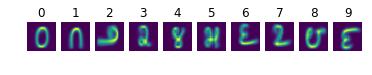

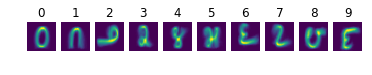

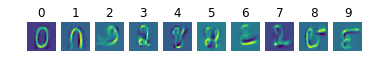

In [0]:
for i in range(10):
    plt.subplot(1,2*5, i+1)
    plt.imshow(np.mean(X_train[y_train==i,:,:,0], axis=0))
    plt.axis('off')
    plt.title(i)
    
plt.figure()

for i in range(10):
    plt.subplot(1,2*5, i+1)
    plt.imshow(np.mean(X_test[y_test==i,:,:,0], axis=0))
    plt.axis('off')
    plt.title(i)
    
plt.figure()

for i in range(10):
    plt.subplot(1,2*5, i+1)
    X_diff_i=np.mean(X_train[y_train==i,:,:,0], axis=0)-np.mean(X_test[y_test==i,:,:,0], axis=0)
    plt.imshow(X_diff_i)
    plt.axis('off')
    plt.title(i)
sanity_check_tri(cnn_model,X_train,X_test)

# 3: Training an off-the-shelf CNN.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping ,LearningRateScheduler

def cnn_train_test(X_train,X_test,y_train,y_test,MODEL_NAME,VERBOSE_FLAG=1,NUM_EPOCHS=1,
                   PLOT_VIZ=False,TRAIN_TEST_PLOT_NAME='tt_acc.png'):
  batch_size = 128
  num_classes = 10
#   epochs = 12

  # input image dimensions
  img_rows, img_cols = 28, 28



  if K.image_data_format() == 'channels_first':
      X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
      X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
      X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)

  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_train /= 255
  X_test /= 255
#   print('X_train shape:', X_train.shape)
#   print(X_train.shape[0], 'train samples')
#   print(X_test.shape[0], 'test samples')
  
#   print('Data ranges are:')
#   print(X_train.min(),X_train.max(),X_test.min(),X_test.max())

  # convert class vectors to binary class matrices
  Y_train = keras.utils.to_categorical(y_train, num_classes)
  Y_test = keras.utils.to_categorical(y_test, num_classes)

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='relu',
                   input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

  c_p=ModelCheckpoint(MODEL_NAME, monitor='val_acc', verbose=VERBOSE_FLAG, save_best_only=True, mode='auto', period=1)
  e_s=EarlyStopping (monitor='val_loss', min_delta=0, patience=3, verbose=VERBOSE_FLAG, mode='auto',restore_best_weights=True)
  # l_r=LearningRateScheduler
  callbacks_list=[c_p,e_s]
  history = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=NUM_EPOCHS,
            verbose=VERBOSE_FLAG,
            validation_data=(X_test, Y_test), callbacks=callbacks_list)
  score = model.evaluate(X_test, Y_test, verbose=VERBOSE_FLAG)
  print('Test accuracy:', score[1])

  if (PLOT_VIZ):
    plt.figure(figsize=(12,5))
    # Plot training & validation accuracy values
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')


    # Plot training & validation loss values
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(TRAIN_TEST_PLOT_NAME,png=300)
  return score[1]

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 5s 86us/step - loss: 0.1971 - acc: 0.9394 - val_loss: 0.1672 - val_acc: 0.9480

Epoch 00001: val_acc improved from -inf to 0.94800, saving model to ./models/ka_mnist_cnn_worst_case.h5
Epoch 2/12
60000/60000 [==============================] - 5s 77us/step - loss: 0.0567 - acc: 0.9832 - val_loss: 0.1474 - val_acc: 0.9541

Epoch 00002: val_acc improved from 0.94800 to 0.95410, saving model to ./models/ka_mnist_cnn_worst_case.h5
Epoch 3/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0395 - acc: 0.9882 - val_loss: 0.1274 - val_acc: 0.9629

Epoch 00003: val_acc improved from 0.95410 to 0.96290, saving model to ./models/ka_mnist_cnn_worst_case.h5
Epoch 4/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0320 - acc: 0.9903 - val_loss: 0.1116 - val_acc: 0.9674

Epoch 00004: val_acc improved from 0.96290 to 0.96740, saving model to ./models/

0.9713

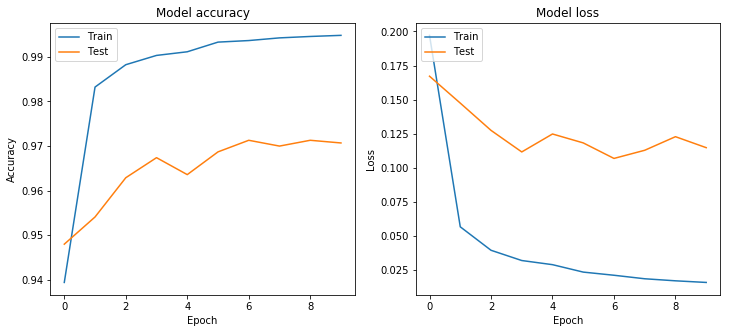

In [0]:
cnn_train_test(X_train,X_test,y_train,y_test,'./models/ka_mnist_cnn_worst_case.h5',VERBOSE_FLAG=1,NUM_EPOCHS=12,
                   PLOT_VIZ=True,TRAIN_TEST_PLOT_NAME='figures/tt_acc_worstcase.png')

In [0]:
np.save('./data/output_tensors/X_train_KaMNIST_wc.npy',X_train)
np.save('./data/output_tensors/X_test_KaMNIST_wc.npy',X_test)
np.save('./data/output_tensors/y_train_KaMNIST_wc.npy',y_train)
np.save('./data/output_tensors/y_test_KaMNIST_wc.npy',y_test)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# OK. So, let's run this for the entire cohort:

In [0]:
def random_cohorts(X_Ka_mnist,y_Ka_mnist):
    chosen_55=np.random.choice(65, 55, replace=False)
    train_users=chosen_55[0:47]
    test_users=chosen_55[47:]


    X_train=X_Ka_mnist[train_users].reshape((47*1280,28,28,1))[0:int(6e4)]
    X_test=X_Ka_mnist[test_users].reshape((8*1280,28,28,1))[0:int(1e4)]


    y_train=y_Ka_mnist[train_users].reshape((47*1280))[0:int(6e4)]
    y_test=y_Ka_mnist[test_users].reshape((8*1280))[0:int(1e4)]
    return X_train,y_train,X_test,y_test,train_users,test_users

In [0]:
from keras.models import load_model
model = load_model('./models/ka_mnist_cnn_worst_case.h5')

Confusion matrix, without normalization
[[913  75   0   8   1   0   0   0   2   1]
 [  3 983   0   9   0   2   0   0   1   2]
 [  3   0 997   0   0   0   0   0   0   0]
 [  3   3   0 980   1   9   2   2   0   0]
 [  0   0   0   3 992   2   1   0   2   0]
 [  0   0   1   5  24 970   0   0   0   0]
 [  0   1   0   1   4   3 974   1   2  14]
 [ 14   2   2  12  13   1  51 901   0   4]
 [  2   0   1   0   2   0   0   0 993   2]
 [  3   0   0   0   3   0   1   0  11 982]]
Normalized confusion matrix
[[0.91 0.07 0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.98 0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.98 0.   0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.02 0.97 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.97 0.   0.   0.01]
 [0.01 0.   0.   0.01 0.01 0.   0.05 0.9  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
 [0.   0.   0.   0.   0.

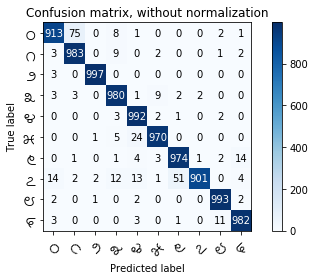

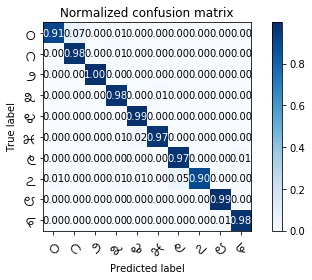

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from __future__ import unicode_literals
# from fontTools.ttLib import TTFont
import matplotlib.font_manager as mfm

def plot_confusion_matrix_KaMNIST(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,file_name='test.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # Customized this one!
    classes = ['೦', '೧', '೨', '೩', '೪', '೫', '೬', '೭', '೮', '೯']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    font_path = './fonts/Kannada/Hubballi-Regular.ttf'
    prop = mfm.FontProperties(fname=font_path) # find this font
    ax.set_xticklabels(labels=classes,fontproperties=prop,fontsize=20)
    ax.set_yticklabels(labels=classes,fontproperties=prop,fontsize=20)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(file_name,dpi=300)
    
    return ax
###############################################
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

np.set_printoptions(precision=2)
y_pred=model.predict_classes(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix_KaMNIST(y_test.astype(int), y_pred, 
                      title='Confusion matrix, without normalization',file_name='figures/worst_case_cmat_unnorm.png')

# # Plot normalized confusion matrix
plot_confusion_matrix_KaMNIST(y_test.astype(int), y_pred, normalize=True,
                      title='Normalized confusion matrix',file_name='figures/worst_case_cmat_norm.png')


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9702    0.9130    0.9408      1000
           1     0.9239    0.9830    0.9525      1000
           2     0.9960    0.9970    0.9965      1000
           3     0.9627    0.9800    0.9713      1000
           4     0.9538    0.9920    0.9725      1000
           5     0.9828    0.9700    0.9763      1000
           6     0.9466    0.9740    0.9601      1000
           7     0.9967    0.9010    0.9464      1000
           8     0.9822    0.9930    0.9876      1000
           9     0.9771    0.9820    0.9796      1000

    accuracy                         0.9685     10000
   macro avg     0.9692    0.9685    0.9684     10000
weighted avg     0.9692    0.9685    0.9684     10000

